# Variational Auto Encoder

- `01.ddpm.ipynb` 파일에서 이미지에 노이즈를 추가하고 그 노이즈를 예측하는 네트워크를 학습했습니다. [en] In the `01.ddpm.ipynb` file, we trained a network to add noise to images and predict that noise.

- 학습된 네트워크에 가우시안 노이즈를 입력하고 노이즈를 한 단계씩 제거하여 이미지를 생성하였습니다. 그 과정에서 이미지의 레이블을 조건으로 입력하여 특정 조건에 맞는 이미지를 생성할 수 있었습니다. [en] By adding Gaussian noise into the trained network, we generated images by denoising them step by step. During this process, we provided image labels as conditions, enabling the generation of images that matched specific conditions.

<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/ldm-figure3.png" width=700>

- 최신의 이미지 생성 모델은 노이즈 제거 작업을 이미지 차원에서 수행하지 않습니다. [en] The latest image generation models do not perform noise removal operations directly on the image dimensions.

- 위 그림이 이를 표현하고 있습니다. 이미지를 잠재 변수 공간으로 임베딩하고 잠재 변수 공간에서 앞서 했던 작업을 수행합니다. 이를 위해 가장 먼저 필요한것은 이미지로 부터 잠재 변수 `z`를 만드는 이미지 인코더가 필요합니다. [en] The above figure illustrates this process. Images are embedded into a latent variable space, where the previously mentioned operations are performed. To achieve this, the first requirement is an image encoder that generates the latent variable `z` from the input image.

- 이 파일에서는 이를 위해 Variational AutoEncoder를 만들도록 하겠습니다. [en] In this file, we will create a Variational AutoEncoder (VAE) for this purpose.

In [1]:
# import the necessary packages
import os, random, shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Prepare Dataset



In [3]:
!gdown 1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ

Downloading...
From: https://drive.google.com/uc?id=1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ
To: /content/sprites_1788_16x16.npy
100% 68.7M/68.7M [00:02<00:00, 29.2MB/s]


In [4]:
sprites = np.load('sprites_1788_16x16.npy')

In [5]:
# define model hyperparameters
IMAGE_SIZE = 16
CHANNELS = 3

# VAE가 만드는 잠재 변수의 채널 개수 [en] Number of channels in latent variables created by VAE
LATENT_EMB_DIM = 4
# VAE가 만드는 잠재변수의 공간 차원 크기 [en] The spatial dimension size of the latent space created by the VAE
LATENT_HEIGHT = 8
LATENT_WIDTH = 8

### Set Image Augmentation

In [6]:
# Define the transformations
train_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]
)
valid_transforms = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

### Dataset and DataLoader

In [7]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        x_0 = self.data[i]

        if self.transform:
            x_0 = self.transform(x_0)

        return x_0

In [8]:
# 전역 난수 생성기 시드 설정
def set_seed(seed_value=42):
    random.seed(seed_value)  # Python
    np.random.seed(seed_value)  # Numpy
    torch.manual_seed(seed_value)  # PyTorch
    torch.cuda.manual_seed_all(seed_value)  # Pytorch All GPU
    # torch.backends.cudnn.deterministic = True  # Set CUDNN to deterministic mode (may reduce speed)
    # torch.backends.cudnn.benchmark = False  Disable CUDNN benchmark (may reduce speed)

# Set seed value for reproducibility
seed = 100
set_seed(seed)
g = torch.Generator().manual_seed(seed)

train_dataset, valid_dataset = random_split(
    sprites, [80000, 9400], generator=g)

train_ds = MyDataset(np.array(train_dataset), train_transforms)
valid_ds = MyDataset(np.array(valid_dataset), valid_transforms)

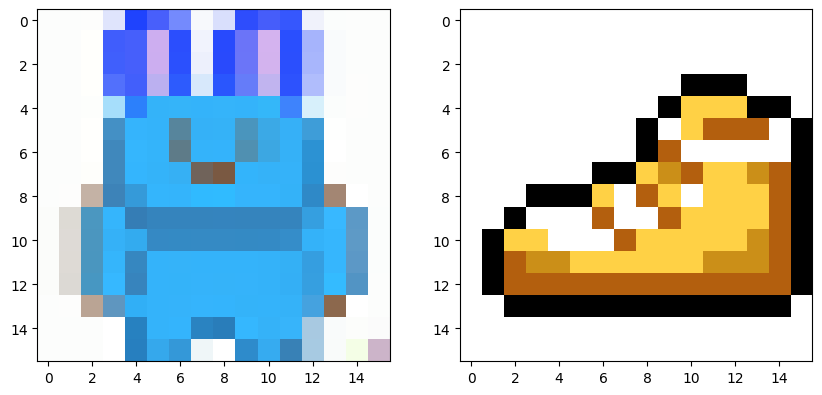

In [9]:
# train and valid set sample
fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=2)

ax[0].imshow(train_ds[0].permute(1,2,0))
ax[1].imshow(valid_ds[0].permute(1,2,0))

plt.show()

In [10]:
# define dataloader
BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
train_loader_iter = iter(train_loader)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader_iter = iter(valid_loader)

## Modeling

### Loss Function

오토인코더의 이미지 복원을 위한 손실 함수를 정의합니다. 손실함수에 대한 자세한 설명은 생략합니다.

In [11]:
def loss_function(VAELossParams, kld_weight):
    recons, input, mu, log_var = VAELossParams

    # MSE loss for image reconstruction
    recons_loss = F.mse_loss(recons, input)

    # latent_dim으로 합하고, 샘플에 대해서 평균 [en] Combine into latent_dim and compute the mean over samples
    # 마지막 특징이 (N, C, H, W) 이기 때문에 sum할때 axis=1,2,3에 다 합해야 함
    # [en] Since the final feature is (N, C, H, W), sum over axis=1,2,3
    kld_loss = torch.mean(
        -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=(1,2,3)), dim=0
    )

    loss = recons_loss + kld_weight * kld_loss

    return {
        "loss": loss,
        "Reconstruction_Loss": recons_loss.detach(),
        "KLD": kld_loss.detach(),
    }

### Validation Loss Fuction
- 학습 중에 이 함수를 사용해서 검증 데이터 에 대한 로스를 계산

In [12]:
def validate(model, val_dataloader, device):
    running_loss = 0.0

    model.eval()

    with torch.no_grad():
        for i, x in enumerate(val_dataloader):
            x = x.to(device)
            predictions = model(x)
            total_loss = loss_function(predictions, KLD_WEIGHT)
            running_loss += total_loss["loss"].item()

    return running_loss / len(val_dataloader)

### Convolution Block

이미지 인코더와 디코더에 사용할 컨볼루션 레이어 블록을 정의 합니다. 기본적으로 이미지 크기를 1/2로 줄이거나 2배로 늘리는 역할도 함께 담당합니다.

In [13]:
# define a convolutional block for the encoder part of the vae
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()

        # sequential block consisting of a 2d convolution,
        # batch normalization, and leaky relu activation
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels,  # number of input channels
                out_channels=out_channels,  # number of output channels
                kernel_size=kernel_size,  # size of the convolutional kernel
                stride=stride,  # stride of the convolution
                padding=padding,  # padding added to the input
            ),
            torch.nn.BatchNorm2d(out_channels),  # normalize the activations of the layer
            torch.nn.LeakyReLU(),  # apply leaky relu activation
        )

    def forward(self, x):
        # pass the input through the sequential block
        return self.block(x)

In [14]:
# define a transposed convolutional block for the decoder part of the vae
class ConvTBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
        super().__init__()

        # sequential block consisting of a transposed 2d convolution,
        # batch normalization, and leaky relu activation
        self.block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels,  # number of input channels
                out_channels,  # number of output channels
                kernel_size=kernel_size,  # size of the convolutional kernel
                stride=stride,  # stride of the convolution
                padding=padding,  # padding added to the input
                output_padding=output_padding,  # additional padding added to the output
            ),
            torch.nn.BatchNorm2d(out_channels),  # normalize the activations of the layer
            torch.nn.LeakyReLU(),  # apply leaky relu activation
        )

    def forward(self, x):
        return self.block(x)  # pass the input through the sequential block

### Define Model

In [15]:
# define the main vae class
class VAE(torch.nn.Module):
    """
    image          encoder        latent       decoder         final layer
    (3, 16, 16) -> (128, 8, 8) -> (4, 8, 8) -> (128, 16, 16) -> (16, 16, 16) -> (3, 16, 16)
    """
    def __init__(self, in_channels, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim  # dimensionality of the latent space
        hidden_dims = [128,]  # hidden dimensions
        # img size     8

        self.encoder = torch.nn.Sequential(
            # (3,16,16) -> (128,8,8)
            ConvBlock(in_channels, hidden_dims[0]),
            # hidden_dims에 추가 레이어가 있으면 [en] If there are additional layers in hidden_dims
            # ConvBlock(hidden_dims[0], hidden_dims[1]),
            # ConvBlock(hidden_dims[1], hidden_dims[2]), ...
        )

        # layer for the mean of the latent space
        self.conv_mu = torch.nn.Conv2d(hidden_dims[-1], latent_dim, kernel_size=3, stride=1, padding=1)

        # layer for the variance of the latent space
        self.conv_var = torch.nn.Conv2d(hidden_dims[-1], latent_dim, kernel_size=3, stride=1, padding=1)


        self.decoder = torch.nn.Sequential(
            ConvTBlock(latent_dim, hidden_dims[-1]),
            # hidden_dims에 추가 레이어가 있으면 [en] If there are additional layers in hidden_dims
            # ConvTBlock(hidden_dims[-1], hidden_dims[-2]),
            # ConvTBlock(hidden_dims[-2], hidden_dims[-3]), ...
        )

        # final layer to reconstruct the original input
        self.final_layer = torch.nn.Sequential(
            torch.nn.Conv2d(
                hidden_dims[0], hidden_dims[0],
                kernel_size=3, stride=1, padding=1
            ),

            # normalize the activations of the layer
            torch.nn.BatchNorm2d(hidden_dims[0]),

            # apply leaky relu activation
            torch.nn.LeakyReLU(),

            # final convolution to match the output channels
            torch.nn.Conv2d(hidden_dims[0], out_channels=3, kernel_size=3, stride=1, padding=1),
        )

    # encoding function to map the input to the latent space
    def encode(self, input):
        # pass the input through the encoder
        result = self.encoder(input) # (B,3,16,16)->(B,128,8,8)

        # compute the mean of the latent space
        mu = self.conv_mu(result) # (B,128,8,8)->(B,4,8,8)

        # compute the log variance of the latent space
        log_var = self.conv_var(result) # (B,128,8,8)->(B,4,8,8)

        return [mu, log_var]

        # decoding function to map the latent space to the reconstructed input
    def decode(self, z):
        # pass the result through the decoder
        result = self.decoder(z) # (B,4,8,8) -> (B,128,16,16)

        # pass the result through the final layer
        result = self.final_layer(result) # (B,128,16,16)->(B,128,16,16)->(B,3,16,16)
        return result

        # reparameterization trick to sample from the latent space
    def reparameterize(self, mu, logvar):
        # compute the standard deviation from the log variance
        std = torch.exp(0.5 * logvar)
        # sample random noise
        eps = torch.randn_like(std)
        # compute the sample from the latent space
        return eps * std + mu

    # forward pass of the vae
    def forward(self, input):
        # encode the input to the latent space
        mu, log_var = self.encode(input) # (B, 3, 16, 16) -> [(B, 4, 8, 8), (B, 4, 8, 8)]

        # sample from the latent space
        z = self.reparameterize(mu, log_var) # [(B, 4, 8, 8), (B, 4, 8, 8)] -> (B, 4, 8, 8)

        # decode the sample, and return the reconstruction
        # along with the original input, mean, and log variance
        recon_input = self.decode(z) # (B, 4, 8, 8) -> (B, 3, 16, 16)

        return [recon_input, input, mu, log_var]

### Model Forward Test

In [16]:
model = VAE(CHANNELS, LATENT_EMB_DIM)

x_test:  torch.Size([5, 3, 16, 16])
reconstruction:  torch.Size([5, 3, 16, 16])


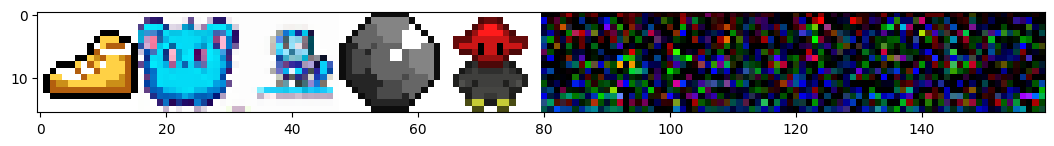

In [17]:
# 검증 셋으로 부터 테스트용 샘플 가져오기, Take test samples from the validation set
x_test = next(val_loader_iter)[:5].clone()
print('x_test: ', x_test.shape)

predictions = model(x_test)
print('reconstruction: ', predictions[0].shape)

fig = plt.figure(figsize=(13,5))
plt.imshow(torch.cat([x_test, predictions[0]]).permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

## Training

### Set Hyper Param.

In [18]:
EPOCHS = 50
# KL divergence loss weight
# Cited from Appendix G of the paper
# To obtain high-fidelity reconstructions we only use a very small regularization for both scenarios,
# i.e. we either weight the KL term by a factor 10^-6 or choose a high codebook dimensionality Z.
KLD_WEIGHT = 0.000001

### Optimizer and Learning Rate Scheduler

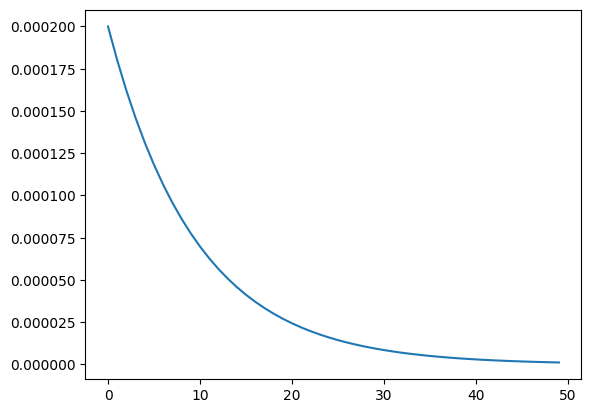

0.0002

In [19]:
learning_rate = 0.0002
scheduler_gamma = 0.9

# Visualize the lr_scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
lrs = []
for i in range(EPOCHS):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(EPOCHS),lrs)
plt.show()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)
optimizer.param_groups[0]['lr']

### Set Checkpoint

In [20]:
# create output directory
output_dir = "assets"
os.makedirs(output_dir, exist_ok=True)

# create the model_weights directory inside the `output_dir`
# for storing autoencoder weights
model_weights_dir = os.path.join(output_dir, f"vae_latent_2d_emb{LATENT_EMB_DIM}")
os.makedirs(model_weights_dir, exist_ok=True)

# define model_weights path including best weighs
MODEL_BEST_WEIGHTS_PATH = os.path.join(model_weights_dir, "best_vae.pt")

Training Started!!


100%|██████████| 625/625 [00:25<00:00, 24.64it/s]


[EPOCH: 1] SAVE BEST MODEL!!
Epoch 1/50, Batch 625/625, Total Loss: 0.0109, Reconstruction Loss: 0.0099, KL Divergence Loss: 962.9681 Val Loss: 0.0106


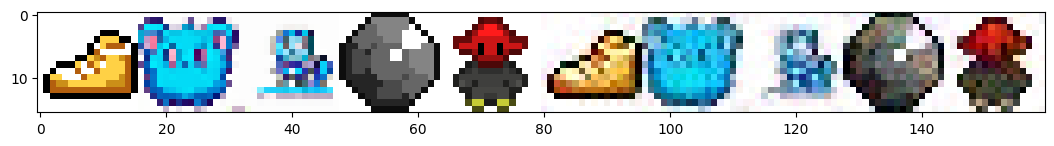

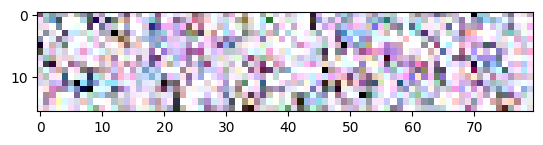

100%|██████████| 625/625 [00:23<00:00, 26.57it/s]


[EPOCH: 2] SAVE BEST MODEL!!
Epoch 2/50, Batch 625/625, Total Loss: 0.0093, Reconstruction Loss: 0.0083, KL Divergence Loss: 954.8759 Val Loss: 0.0098


100%|██████████| 625/625 [00:24<00:00, 25.83it/s]


[EPOCH: 3] SAVE BEST MODEL!!
Epoch 3/50, Batch 625/625, Total Loss: 0.0083, Reconstruction Loss: 0.0073, KL Divergence Loss: 926.7959 Val Loss: 0.0079


100%|██████████| 625/625 [00:23<00:00, 26.71it/s]


[EPOCH: 4] SAVE BEST MODEL!!
Epoch 4/50, Batch 625/625, Total Loss: 0.0071, Reconstruction Loss: 0.0062, KL Divergence Loss: 907.8551 Val Loss: 0.0073


100%|██████████| 625/625 [00:23<00:00, 26.65it/s]


[EPOCH: 5] SAVE BEST MODEL!!
Epoch 5/50, Batch 625/625, Total Loss: 0.0071, Reconstruction Loss: 0.0062, KL Divergence Loss: 899.3318 Val Loss: 0.0068


100%|██████████| 625/625 [00:23<00:00, 26.55it/s]


[EPOCH: 6] SAVE BEST MODEL!!
Epoch 6/50, Batch 625/625, Total Loss: 0.0070, Reconstruction Loss: 0.0061, KL Divergence Loss: 892.4050 Val Loss: 0.0067


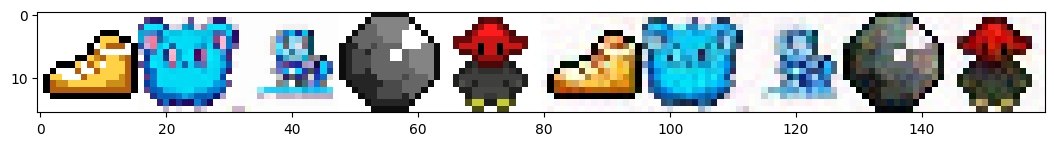

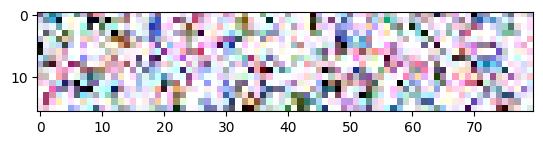

100%|██████████| 625/625 [00:23<00:00, 26.45it/s]


[EPOCH: 7] SAVE BEST MODEL!!
Epoch 7/50, Batch 625/625, Total Loss: 0.0071, Reconstruction Loss: 0.0062, KL Divergence Loss: 890.6820 Val Loss: 0.0064


100%|██████████| 625/625 [00:23<00:00, 26.36it/s]


[EPOCH: 8] SAVE BEST MODEL!!
Epoch 8/50, Batch 625/625, Total Loss: 0.0069, Reconstruction Loss: 0.0061, KL Divergence Loss: 885.4011 Val Loss: 0.0064


100%|██████████| 625/625 [00:24<00:00, 25.45it/s]


Epoch 9/50, Batch 625/625, Total Loss: 0.0066, Reconstruction Loss: 0.0057, KL Divergence Loss: 878.1292 Val Loss: 0.0066


100%|██████████| 625/625 [00:23<00:00, 26.25it/s]


[EPOCH: 10] SAVE BEST MODEL!!
Epoch 10/50, Batch 625/625, Total Loss: 0.0059, Reconstruction Loss: 0.0051, KL Divergence Loss: 880.2988 Val Loss: 0.0060


100%|██████████| 625/625 [00:23<00:00, 26.37it/s]


Epoch 11/50, Batch 625/625, Total Loss: 0.0059, Reconstruction Loss: 0.0050, KL Divergence Loss: 876.5151 Val Loss: 0.0061


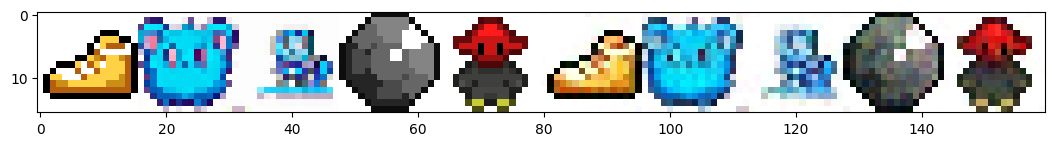

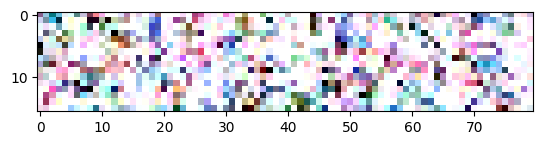

100%|██████████| 625/625 [00:23<00:00, 26.20it/s]


[EPOCH: 12] SAVE BEST MODEL!!
Epoch 12/50, Batch 625/625, Total Loss: 0.0057, Reconstruction Loss: 0.0048, KL Divergence Loss: 871.9391 Val Loss: 0.0059


100%|██████████| 625/625 [00:23<00:00, 26.10it/s]


Epoch 13/50, Batch 625/625, Total Loss: 0.0058, Reconstruction Loss: 0.0049, KL Divergence Loss: 867.5327 Val Loss: 0.0062


100%|██████████| 625/625 [00:23<00:00, 26.06it/s]


[EPOCH: 14] SAVE BEST MODEL!!
Epoch 14/50, Batch 625/625, Total Loss: 0.0058, Reconstruction Loss: 0.0049, KL Divergence Loss: 865.6384 Val Loss: 0.0057


100%|██████████| 625/625 [00:23<00:00, 26.17it/s]


Epoch 15/50, Batch 625/625, Total Loss: 0.0058, Reconstruction Loss: 0.0050, KL Divergence Loss: 862.3302 Val Loss: 0.0058


100%|██████████| 625/625 [00:23<00:00, 26.13it/s]


[EPOCH: 16] SAVE BEST MODEL!!
Epoch 16/50, Batch 625/625, Total Loss: 0.0055, Reconstruction Loss: 0.0046, KL Divergence Loss: 866.6983 Val Loss: 0.0056


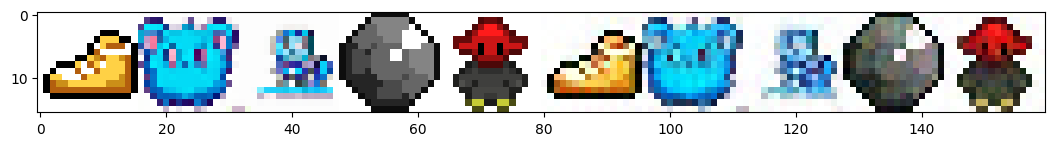

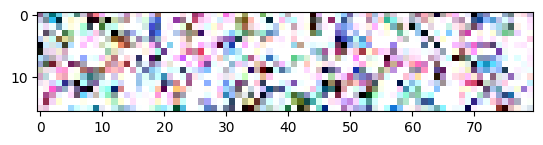

100%|██████████| 625/625 [00:24<00:00, 25.98it/s]


Epoch 17/50, Batch 625/625, Total Loss: 0.0058, Reconstruction Loss: 0.0049, KL Divergence Loss: 860.5554 Val Loss: 0.0057


100%|██████████| 625/625 [00:23<00:00, 26.05it/s]


[EPOCH: 18] SAVE BEST MODEL!!
Epoch 18/50, Batch 625/625, Total Loss: 0.0055, Reconstruction Loss: 0.0047, KL Divergence Loss: 857.1788 Val Loss: 0.0055


100%|██████████| 625/625 [00:24<00:00, 25.12it/s]


Epoch 19/50, Batch 625/625, Total Loss: 0.0057, Reconstruction Loss: 0.0049, KL Divergence Loss: 858.5452 Val Loss: 0.0056


100%|██████████| 625/625 [00:24<00:00, 25.96it/s]


[EPOCH: 20] SAVE BEST MODEL!!
Epoch 20/50, Batch 625/625, Total Loss: 0.0058, Reconstruction Loss: 0.0050, KL Divergence Loss: 857.4045 Val Loss: 0.0055


100%|██████████| 625/625 [00:23<00:00, 26.09it/s]


[EPOCH: 21] SAVE BEST MODEL!!
Epoch 21/50, Batch 625/625, Total Loss: 0.0057, Reconstruction Loss: 0.0048, KL Divergence Loss: 855.9301 Val Loss: 0.0054


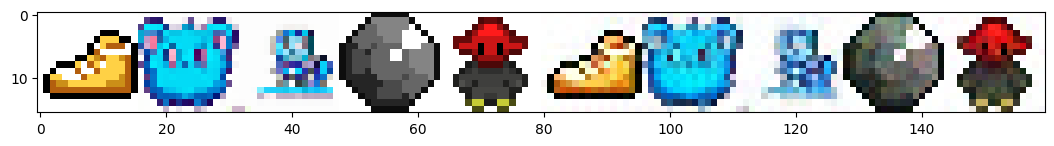

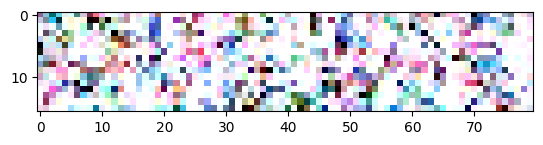

100%|██████████| 625/625 [00:23<00:00, 26.11it/s]


[EPOCH: 22] SAVE BEST MODEL!!
Epoch 22/50, Batch 625/625, Total Loss: 0.0061, Reconstruction Loss: 0.0052, KL Divergence Loss: 856.5530 Val Loss: 0.0054


100%|██████████| 625/625 [00:24<00:00, 25.97it/s]


[EPOCH: 23] SAVE BEST MODEL!!
Epoch 23/50, Batch 625/625, Total Loss: 0.0056, Reconstruction Loss: 0.0048, KL Divergence Loss: 853.8386 Val Loss: 0.0054


100%|██████████| 625/625 [00:24<00:00, 26.02it/s]


[EPOCH: 24] SAVE BEST MODEL!!
Epoch 24/50, Batch 625/625, Total Loss: 0.0055, Reconstruction Loss: 0.0047, KL Divergence Loss: 853.1720 Val Loss: 0.0053


100%|██████████| 625/625 [00:23<00:00, 26.09it/s]


[EPOCH: 25] SAVE BEST MODEL!!
Epoch 25/50, Batch 625/625, Total Loss: 0.0056, Reconstruction Loss: 0.0048, KL Divergence Loss: 855.8483 Val Loss: 0.0053


100%|██████████| 625/625 [00:23<00:00, 26.06it/s]


Epoch 26/50, Batch 625/625, Total Loss: 0.0055, Reconstruction Loss: 0.0046, KL Divergence Loss: 850.0522 Val Loss: 0.0054


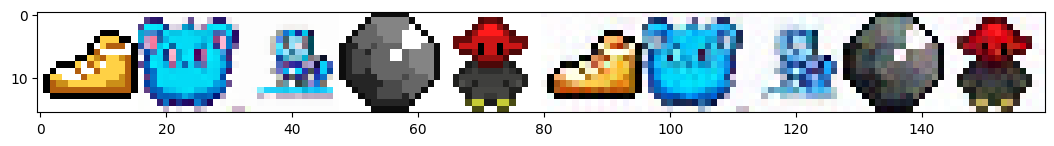

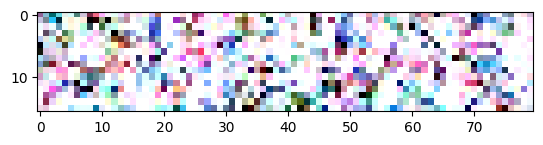

100%|██████████| 625/625 [00:24<00:00, 25.95it/s]


[EPOCH: 27] SAVE BEST MODEL!!
Epoch 27/50, Batch 625/625, Total Loss: 0.0056, Reconstruction Loss: 0.0047, KL Divergence Loss: 850.1213 Val Loss: 0.0053


100%|██████████| 625/625 [00:23<00:00, 26.11it/s]


Epoch 28/50, Batch 625/625, Total Loss: 0.0056, Reconstruction Loss: 0.0047, KL Divergence Loss: 853.3082 Val Loss: 0.0053


100%|██████████| 625/625 [00:24<00:00, 25.29it/s]


Epoch 29/50, Batch 625/625, Total Loss: 0.0061, Reconstruction Loss: 0.0052, KL Divergence Loss: 855.4272 Val Loss: 0.0053


100%|██████████| 625/625 [00:23<00:00, 26.18it/s]


[EPOCH: 30] SAVE BEST MODEL!!
Epoch 30/50, Batch 625/625, Total Loss: 0.0053, Reconstruction Loss: 0.0044, KL Divergence Loss: 850.3348 Val Loss: 0.0053


100%|██████████| 625/625 [00:23<00:00, 26.17it/s]


[EPOCH: 31] SAVE BEST MODEL!!
Epoch 31/50, Batch 625/625, Total Loss: 0.0054, Reconstruction Loss: 0.0046, KL Divergence Loss: 853.2963 Val Loss: 0.0053


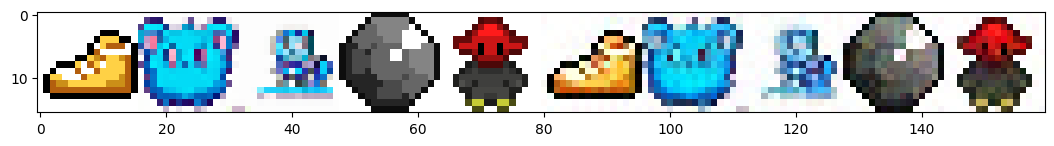

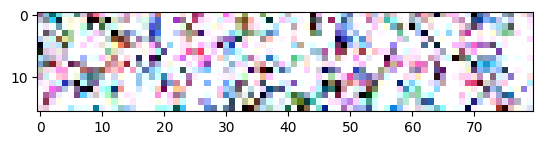

100%|██████████| 625/625 [00:24<00:00, 25.82it/s]


[EPOCH: 32] SAVE BEST MODEL!!
Epoch 32/50, Batch 625/625, Total Loss: 0.0051, Reconstruction Loss: 0.0042, KL Divergence Loss: 846.7428 Val Loss: 0.0052


100%|██████████| 625/625 [00:23<00:00, 26.09it/s]


Epoch 33/50, Batch 625/625, Total Loss: 0.0052, Reconstruction Loss: 0.0044, KL Divergence Loss: 847.2207 Val Loss: 0.0053


100%|██████████| 625/625 [00:24<00:00, 25.90it/s]


[EPOCH: 34] SAVE BEST MODEL!!
Epoch 34/50, Batch 625/625, Total Loss: 0.0053, Reconstruction Loss: 0.0045, KL Divergence Loss: 853.7148 Val Loss: 0.0052


100%|██████████| 625/625 [00:23<00:00, 26.14it/s]


[EPOCH: 35] SAVE BEST MODEL!!
Epoch 35/50, Batch 625/625, Total Loss: 0.0056, Reconstruction Loss: 0.0048, KL Divergence Loss: 852.3300 Val Loss: 0.0052


100%|██████████| 625/625 [00:24<00:00, 26.01it/s]


[EPOCH: 36] SAVE BEST MODEL!!
Epoch 36/50, Batch 625/625, Total Loss: 0.0055, Reconstruction Loss: 0.0047, KL Divergence Loss: 848.6757 Val Loss: 0.0052


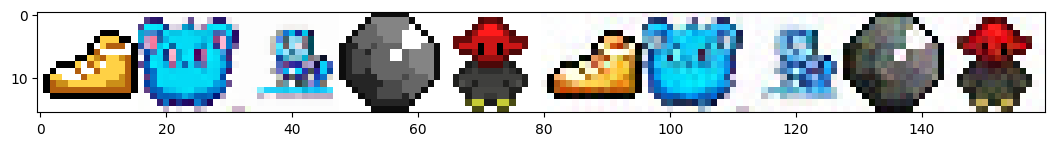

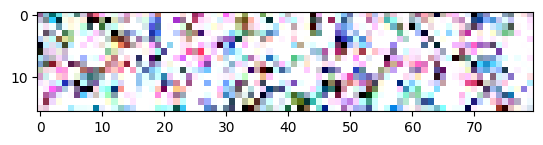

100%|██████████| 625/625 [00:24<00:00, 25.85it/s]


[EPOCH: 37] SAVE BEST MODEL!!
Epoch 37/50, Batch 625/625, Total Loss: 0.0055, Reconstruction Loss: 0.0047, KL Divergence Loss: 848.4387 Val Loss: 0.0052


100%|██████████| 625/625 [00:24<00:00, 25.91it/s]


Epoch 38/50, Batch 625/625, Total Loss: 0.0054, Reconstruction Loss: 0.0046, KL Divergence Loss: 850.5851 Val Loss: 0.0052


100%|██████████| 625/625 [00:24<00:00, 25.17it/s]


[EPOCH: 39] SAVE BEST MODEL!!
Epoch 39/50, Batch 625/625, Total Loss: 0.0055, Reconstruction Loss: 0.0047, KL Divergence Loss: 852.1528 Val Loss: 0.0052


100%|██████████| 625/625 [00:24<00:00, 25.87it/s]


Epoch 40/50, Batch 625/625, Total Loss: 0.0053, Reconstruction Loss: 0.0045, KL Divergence Loss: 845.9893 Val Loss: 0.0052


100%|██████████| 625/625 [00:23<00:00, 26.07it/s]


Epoch 41/50, Batch 625/625, Total Loss: 0.0059, Reconstruction Loss: 0.0050, KL Divergence Loss: 848.0508 Val Loss: 0.0052


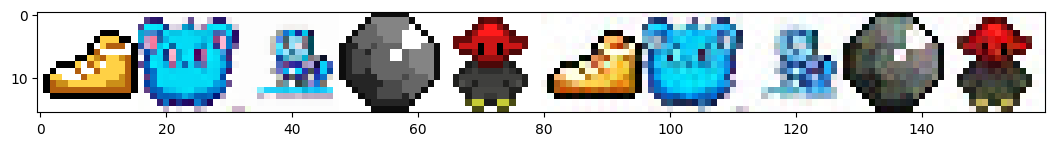

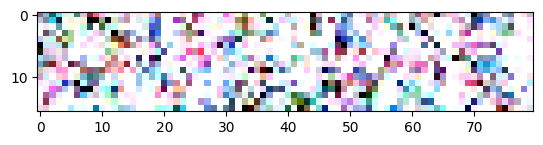

100%|██████████| 625/625 [00:24<00:00, 25.76it/s]


[EPOCH: 42] SAVE BEST MODEL!!
Epoch 42/50, Batch 625/625, Total Loss: 0.0055, Reconstruction Loss: 0.0046, KL Divergence Loss: 851.8495 Val Loss: 0.0052


100%|██████████| 625/625 [00:24<00:00, 25.76it/s]


[EPOCH: 43] SAVE BEST MODEL!!
Epoch 43/50, Batch 625/625, Total Loss: 0.0059, Reconstruction Loss: 0.0051, KL Divergence Loss: 853.9491 Val Loss: 0.0052


100%|██████████| 625/625 [00:23<00:00, 26.24it/s]


Epoch 44/50, Batch 625/625, Total Loss: 0.0052, Reconstruction Loss: 0.0043, KL Divergence Loss: 850.1149 Val Loss: 0.0052


100%|██████████| 625/625 [00:24<00:00, 25.69it/s]


[EPOCH: 45] SAVE BEST MODEL!!
Epoch 45/50, Batch 625/625, Total Loss: 0.0053, Reconstruction Loss: 0.0045, KL Divergence Loss: 849.9385 Val Loss: 0.0052


100%|██████████| 625/625 [00:24<00:00, 25.83it/s]


[EPOCH: 46] SAVE BEST MODEL!!
Epoch 46/50, Batch 625/625, Total Loss: 0.0054, Reconstruction Loss: 0.0046, KL Divergence Loss: 847.8290 Val Loss: 0.0052


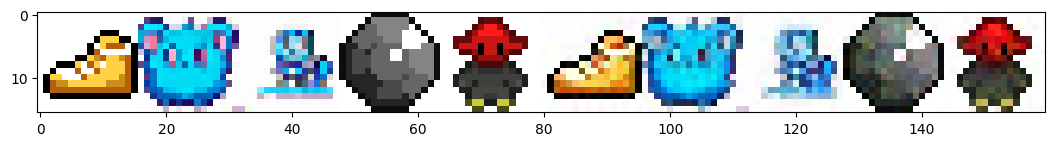

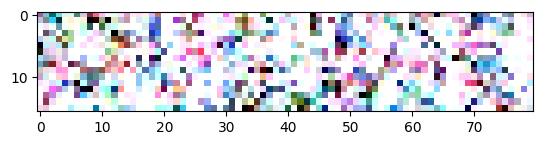

100%|██████████| 625/625 [00:24<00:00, 25.58it/s]


[EPOCH: 47] SAVE BEST MODEL!!
Epoch 47/50, Batch 625/625, Total Loss: 0.0051, Reconstruction Loss: 0.0043, KL Divergence Loss: 847.7607 Val Loss: 0.0052


100%|██████████| 625/625 [00:24<00:00, 25.88it/s]


[EPOCH: 48] SAVE BEST MODEL!!
Epoch 48/50, Batch 625/625, Total Loss: 0.0061, Reconstruction Loss: 0.0053, KL Divergence Loss: 853.7237 Val Loss: 0.0052


100%|██████████| 625/625 [00:24<00:00, 25.13it/s]


[EPOCH: 49] SAVE BEST MODEL!!
Epoch 49/50, Batch 625/625, Total Loss: 0.0054, Reconstruction Loss: 0.0045, KL Divergence Loss: 848.4673 Val Loss: 0.0052


100%|██████████| 625/625 [00:24<00:00, 25.88it/s]


Epoch 50/50, Batch 625/625, Total Loss: 0.0053, Reconstruction Loss: 0.0045, KL Divergence Loss: 847.4966 Val Loss: 0.0052
CPU times: user 20min 14s, sys: 8.96 s, total: 20min 23s
Wall time: 20min 41s


In [21]:
%%time

# initialize the best validation loss as infinity
best_val_loss = float("inf")
print("Training Started!!")

model = model.to(device)
x_test = x_test.to(device)

# Generate Gaussian noise in latent dimensions to test image generation from random noise
random_noise = torch.randn((5, LATENT_EMB_DIM, LATENT_HEIGHT, LATENT_WIDTH)).to(device)

# start training by looping over the number of epochs
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for i, x in enumerate(tqdm(train_loader)):
        x = x.to(device)
        optimizer.zero_grad()
        predictions = model(x)
        total_loss = loss_function(predictions, KLD_WEIGHT)

        # Backward pass
        total_loss["loss"].backward()

        # Optimizer variable updates
        optimizer.step()

        running_loss += total_loss["loss"].item()

    # compute average loss for the epoch
    train_loss = running_loss / len(train_loader)

    # compute validation loss for the epoch
    val_loss = validate(model, valid_loader, device)

    # save best vae model weights based on validation loss
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        torch.save({"vae": model.state_dict()}, MODEL_BEST_WEIGHTS_PATH)
        print(f"[EPOCH: {epoch+1}] SAVE BEST MODEL!!")

    print(
        f"Epoch {epoch+1}/{EPOCHS}, Batch {i+1}/{len(train_loader)}, "
        f"Total Loss: {total_loss['loss'].detach().item():.4f}, "
        f"Reconstruction Loss: {total_loss['Reconstruction_Loss']:.4f}, "
        f"KL Divergence Loss: {total_loss['KLD']:.4f}",
        f"Val Loss: {val_loss:.4f}",
    )

    if epoch % 5 == 0:
        model.eval()
        predictions = model(x_test)
        fig = plt.figure(figsize=(13,5))
        plt.imshow(torch.cat([x_test, predictions[0]]).permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
        plt.show()

        # generate from random noise
        x_recon = model.decode(random_noise)
        plt.imshow(x_recon.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
        plt.show()

    scheduler.step()

### Load Best Model

In [25]:
# model load
model_state = torch.load(MODEL_BEST_WEIGHTS_PATH, weights_only=True)
model.load_state_dict(model_state['vae'])
model.eval();

### Reconstruction Test Samples

- 학습에서 사용한 `x_test`에 대해서 인코딩, 디코딩

In [26]:
mu, log_var = model.encode(x_test)
z = model.reparameterize(mu, log_var)
x_recon = model.decode(z)

x_test.shape, z.shape, x_recon.shape

(torch.Size([5, 3, 16, 16]),
 torch.Size([5, 4, 8, 8]),
 torch.Size([5, 3, 16, 16]))

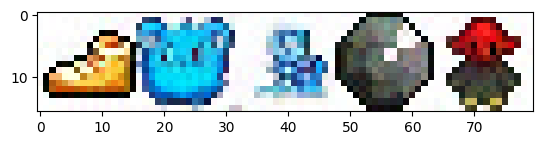

In [27]:
plt.imshow(x_recon.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()